# set-up

In [1]:
# load required libraries
import pandas as pd
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import obonet as obo
import networkx as nx
import requests
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
import matplotlib.patches as mpatches
import json
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks')
from rca_functions import import_seedgenes, import_interactome
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [4]:
tissue_network=False
interactome_name='PCNet2.0'
if tissue_network==False:
    interactome_name='PCNet2.0'
    if interactome_name=='PCNet2.0':
        all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
    else:
        interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
        all_nodes=list(interactome.nodes())

# import NPS scores and seed genes

In [5]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,psych_traits,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol'])
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [6]:
UUIDs

{'PCNet2.0': 'd73d6357-e87b-11ee-9621-005056ae23aa',
 'PCNet2.1': 'e9c574f4-e87a-11ee-9621-005056ae23aa',
 'PCNet2.2': '8b4b54fa-e87d-11ee-9621-005056ae23aa',
 'HumanNetv3FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'HumanNetv3XC': '8f929fb5-3ac6-11ed-b7d0-0ac135e8bacf',
 'STRING': '5f5da339-f14a-11ee-9621-005056ae23aa',
 'signor_rat': '76be57cd-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_human': '523fff27-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_mouse': '656370fa-afe8-11e9-8bb4-0ac135e8bacf'}

In [7]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

# import MGI datasets

In [8]:
# load mappings between genes and mammalian phenotypes
mgi_df = validation.load_MGI_mouseKO_data()
print("Number of gene-phenotype associations:", len(mgi_df))
# import table of names of MPO terms
MPO_desc=import_MPO_description()
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

33 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Cast', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr'
12788 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


26019
13231
13198
Number of gene-phenotype associations: 388898


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


15591


In [9]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

In [10]:
gpt_path='validation_datasets/MGI_genes_per_trait_MP.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait(['MP:0000001'],mgi_df,'human_ortholog','MP',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# choose dataset for analysis- put gene lists into dictionary

In [11]:
traits=['ext_db_FDR',
 'ext_rtb_bonf',
 'bmi_top500',
 'dpw_bonf',
 'maternal_smok_FDR',
 'park_bonf',
 'adhd_FDR']

In [12]:
#modify for correct genesets
trait_r='loco_final_cf'
cut_r= 'FDR'

trait_h='ext'
cut_h='top500'


#choose which community to check enrichment for
#must be keys from coloc_dict

#['seed_r', 'seed_h', 'seed_hr', 'net', 'graph', 'magma_hm_ref', 'magma_rat_ref', 'hm_net', 'rat_net', 'magma_hm_rat_overlap_ref']
sub_community='net'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)


In [13]:
label_h+'-'+label_r+'-'+interactome_name

'ext_top500-loco_final_cf_FDR-PCNet2.0'

In [14]:
filter_traits=False
gpt=genes_per_trait[(genes_per_trait.ngenes>=5)&(genes_per_trait.ngenes<=1e5)]

In [15]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [16]:
for f in coloc_dict['seed_r']:
    print(f)

C1orf116
CLCA1
VIPR2
LYPD6B
GOSR2
PLAGL1
ICAM2
MCOLN2
MMP21
MCOLN3
GABRA4
CASD1
EXOSC9
MINK1
MS4A6A
PECAM1
VPS37C
RAD23B
SLC12A1
VTA1
HMX3
TACO1
SCOC
SHPRH
SP4
C10orf88
PLD2
SRP72
MLF1
C1QBP
GABRG1
SPATA22
PHIP
NOL11
EBF3
RPS10
LMO4
SMARCA5
FUCA2
PDCL2
MBP
PDGFRA
LGALS8
FNTA
POTEH
STRADA
CX3CL1
TANC2
LMO1
METTL2A
IL10
NUAK2
MYEF2
EPM2A
PSMC5
P2RY1
ARVCF
ASPA
PPARD
DERL2
RNF150
NCBP3
ZC2HC1B
PLEKHM1
TRPC3
CUZD1
UTP18
SDCBP
GNG11
DGUOK
SPNS2
UROS
INPP4B
UFD1
WNT2B
WNT9B
TCERG1L
RPRML
MAP3K14
SF3B5
ZNF330
EDRF1
ITGAE
PTGER1
MS4A7
GH1
MBNL1
GALNT13
RABL2B
SPPL2C
IKBKE
NCAPG2
DDX42
STMN4
TACC2
MRC2
GIPC1
PTK2B
ARL2BP
IL19
ZZEF1
LRRTM4
TIPARP
SLC25A11
TMEM68
RPS20
PACSIN1
BAK1
PAX6
OR10K2
SSR3
C17orf58
MAPKAPK2
DHX38
NUGGC
MOS
MFSD1
ACR
POTED
ATP2A3
ESYT2
IL24
ADAT2
PIGR
DMBT1
HMGN3
LEMD1
PCDH18
RGS20
MS4A18
GP1BB
ADGB
MEPE
UTRN
PRKACA
ATP6V1H
MBTD1
ACVR2A
DCAF7
EXOC1L
TFPI2
DDAH1
COMT
ADAM2
TEX2
C10orf120
LYPD6
PAICS
NMU
DDX39A
NR4A2
NDST4
HOPX
CHCHD7
GGNBP1
KCND2
SELENOF
CHIC2
TNNI3K
SDR16

In [17]:
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
if sub_community in val_lab_dict.keys():
    whole_community=coloc_dict_ref[sub_community]
    outpath=f'validation_output/MGI_enr_{val_lab_dict[sub_community]}_enr.csv'

else:
    print('sub_community not in val_lab_dict- using graph as the whole_community')
    whole_community='graph'
    outpath='validation_output/MGI_enr_temp.csv'
print(f'path for this output file: {outpath}')
if (outpath=='validation_output/MGI_enr_temp.csv'):
    print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
elif (os.path.isfile(outpath)):
    run_analysis=False
    print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
    tbl=pd.read_csv(outpath)
else:
    run_analysis=True
    print('this analysis has not been run- run_analysis set to True')

path for this output file: validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True


# validate whole geneset at all depths of the MGI

In [18]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(mgi_df['human_ortholog'].dropna()))

In [19]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')

	THIS IS CALCULATED FROM loco_final_cf_FDR, ext_top500, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)


In [20]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'mammalian phenotype',mgi_df,'MP','human_ortholog',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=None,verbose=False,enr_concat=None)
    tbl.to_csv(outpath,index=False)
    print(f'table saved as {outpath}')

In [21]:
if ('net' in sub_community):
    if not 'n_seed' in tbl.columns: #comment out to fix fucked ones
        if 'community_genes' in tbl.columns:
            col='community_genes'
        else:
            col='network_genes'
        if type(tbl[col].iloc[0])!=set:
            tbl['seed_h']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(', ')).intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(', ')).intersection(coloc_dict['seed_r']))
        else:
            tbl['seed_h']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_r']))
        tbl['n_seed_h']=tbl.seed_h.apply(lambda x: len(list(x)))
        tbl['n_seed_r']=tbl.seed_r.apply(lambda x: len(list(x)))
        tbl['n_seed']=tbl.apply(lambda row: len(row['seed_h'] | row['seed_r']), axis=1)
        if not filter_traits:
            tbl.to_csv(outpath,index=False)
        tbl.sort_values('n_seed',ascending=False).head()

In [22]:
tbl_sub=tbl[tbl.p_intersect<(0.05/len(set(tbl.trait)))]

In [23]:
len(set(tbl['trait']))

3414

In [24]:
(tbl_sub[['trait','odds_ratio','p_intersect','depth']].drop_duplicates())

,trait,odds_ratio,p_intersect,depth
9,behavior/neurological phenotype,2.263534,3.961222e-09,0
24,nervous system phenotype,2.889183,2.972573e-14,0
28,abnormal nervous system physiology,3.257429,2.067607e-15,1
29,abnormal nervous system morphology,2.178718,6.218483e-08,1
90,abnormal behavior,2.264269,3.906954e-09,1
195,abnormal neuron morphology,2.705431,1.311603e-09,2
374,abnormal cognition,2.866159,7.934173e-09,2
375,abnormal behavioral response to xenobiotic,4.876780,1.150011e-08,2
377,abnormal emotion/affect behavior,2.559877,5.418421e-08,2
378,abnormal social/conspecific interaction behavior,3.956413,6.179355e-08,2


In [25]:
if filter_traits:
    print('filtering traits')
    tbl=tbl[tbl.trait.isin(gpt.trait_name)]
if ('n_seed' in tbl.columns):
    tbl[tbl.p_intersect<0.05/len(tbl)].sort_values('n_seed',ascending=False)
else:
    tbl[tbl.p_intersect<0.05/len(tbl)]

# plot enrichment

In [34]:
save_fig=True

In [35]:
if save_fig==True:
    outpath_dir=outpath[:len(outpath)-4]
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [36]:
outpath

'validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv'

In [37]:
colormap=plt.colormaps.get_cmap('tab20b')

In [38]:
len_t=len(tbl)

## scatter plot

In [29]:
len_t=len(set(graph.nodes()))

In [30]:
sigcut=0.05/len_t

In [31]:
sigcut

3.459968168292852e-06

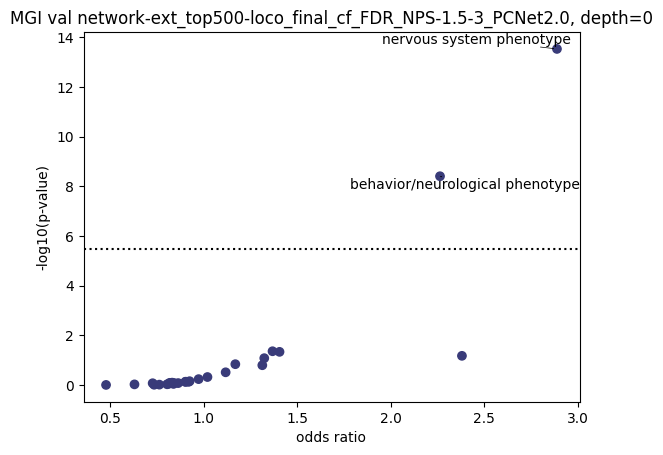

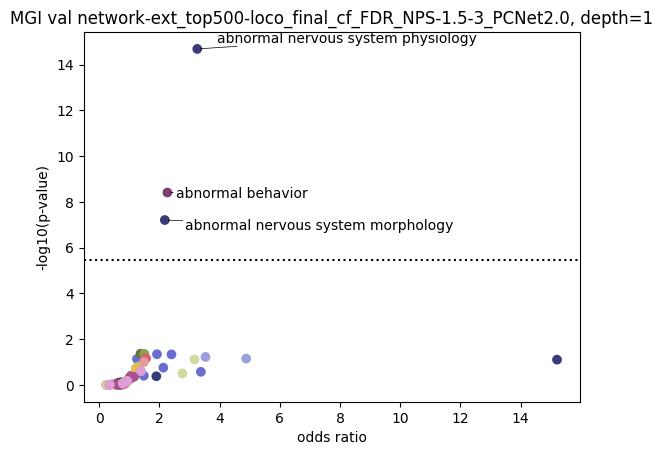

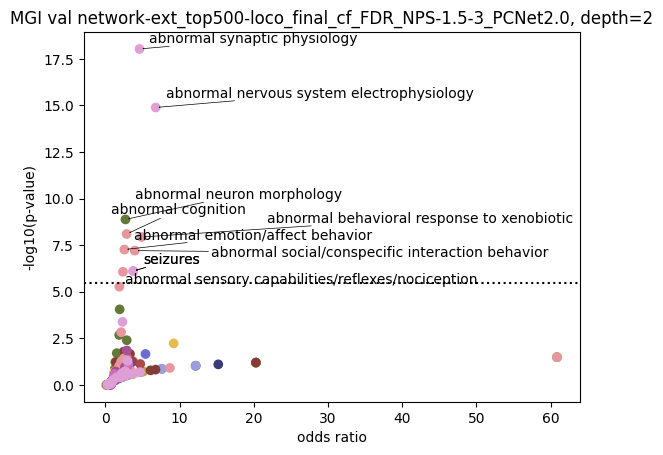

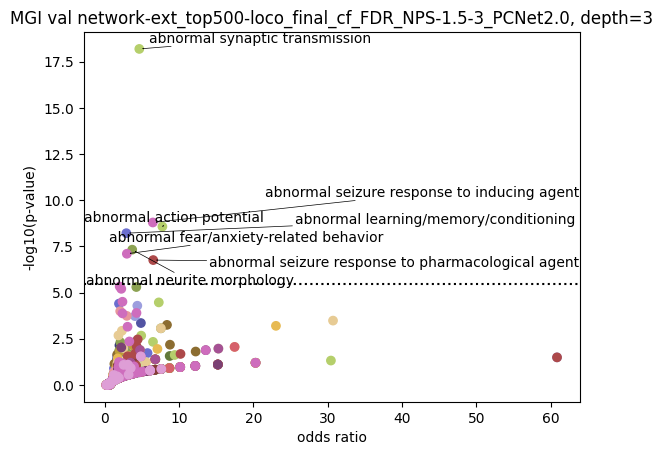

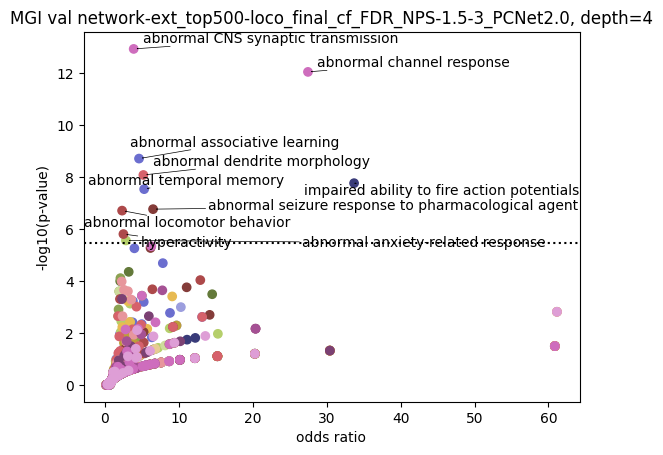

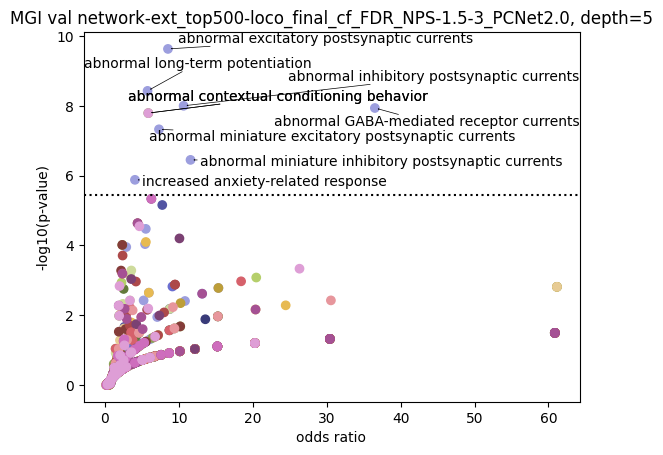

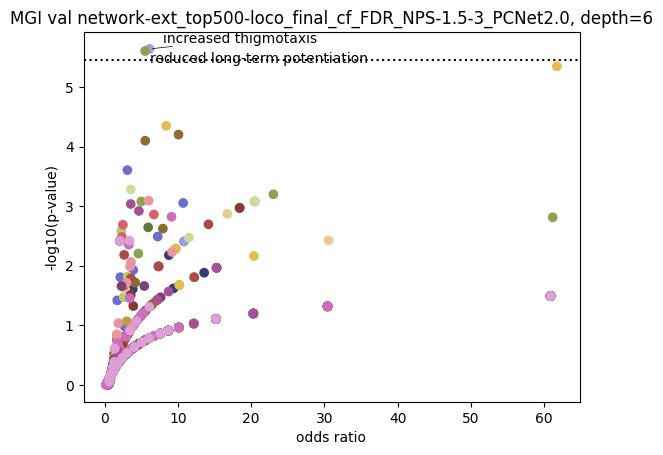

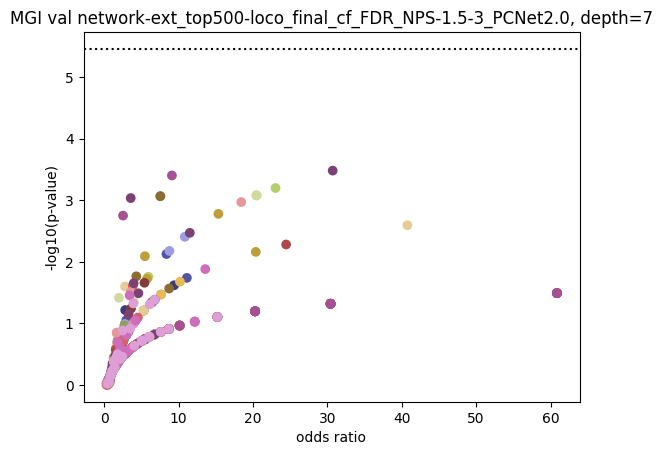

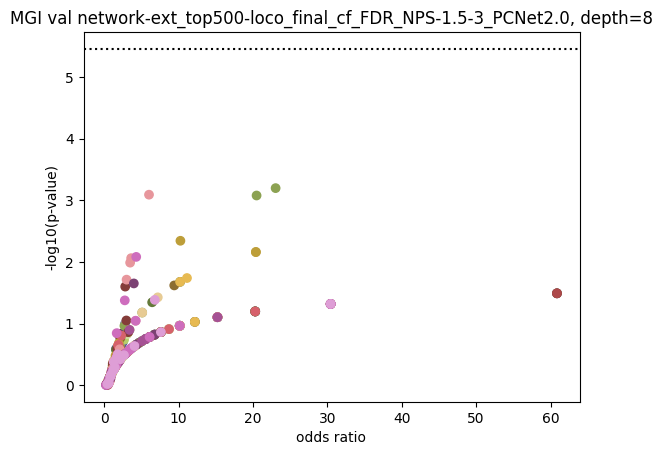

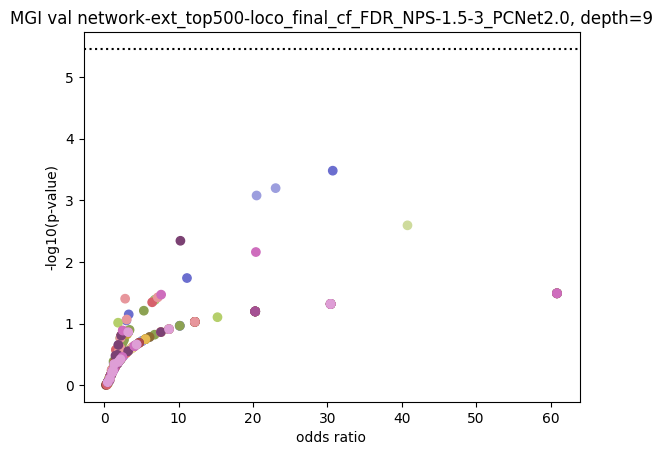

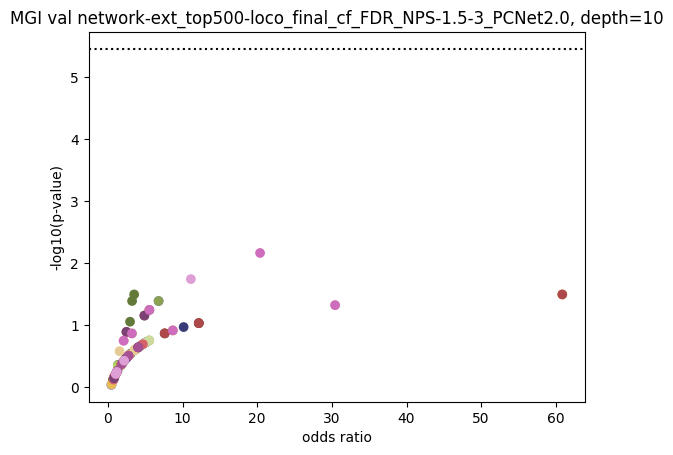

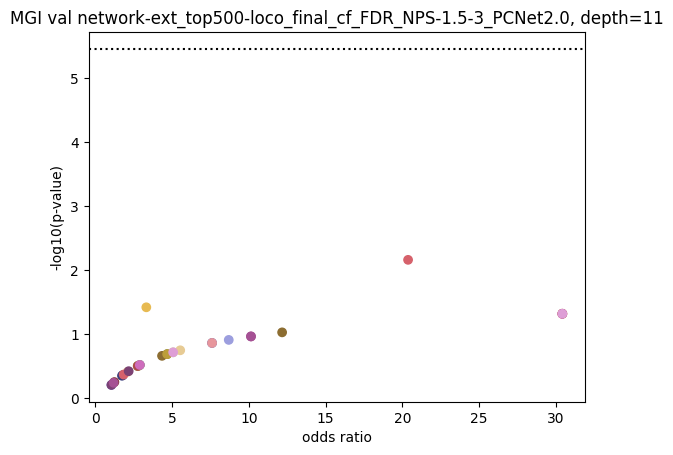

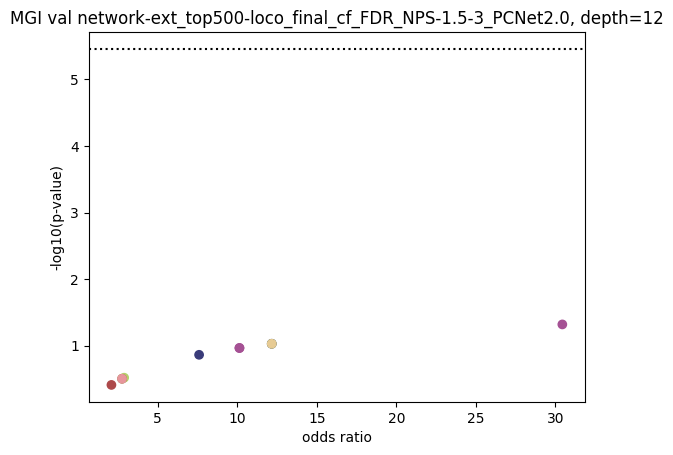

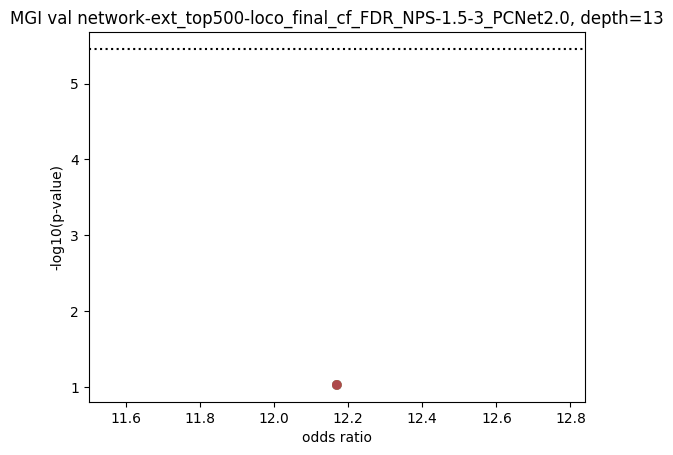

In [152]:
for d in set(tbl.depth):
    t=tbl[tbl.depth==d]
    sigcut=0.05/len_t
    unique_traits = t.parent_trait.unique()
    color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
    colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait

    plt.scatter(x=t.odds_ratio,y=-np.log10(t.p_intersect),color=colors)

    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(sigcut),color='black',ls=':',label='bonferroni')
    plt.title(f'MGI val {val_lab_dict[sub_community]}, depth={d}')
    texts = []
    for i in t.index:
        if (t.p_intersect[i]<(sigcut)):
            texts.append(plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i]))))
    
    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, 
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    
    '''
    legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
    plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
    '''
    if save_fig:
        if not filter_traits:
            plt.savefig((f'{outpath_dir}/MGI_val_scatter_depth-{d}.svg'), bbox_inches = "tight")
        else:
            plt.savefig((f'{outpath_dir}/MGI_val_filtered_scatter_depth-{d}.svg'), bbox_inches = "tight")

    plt.show()

## barplot

In [153]:
save_fig=True

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


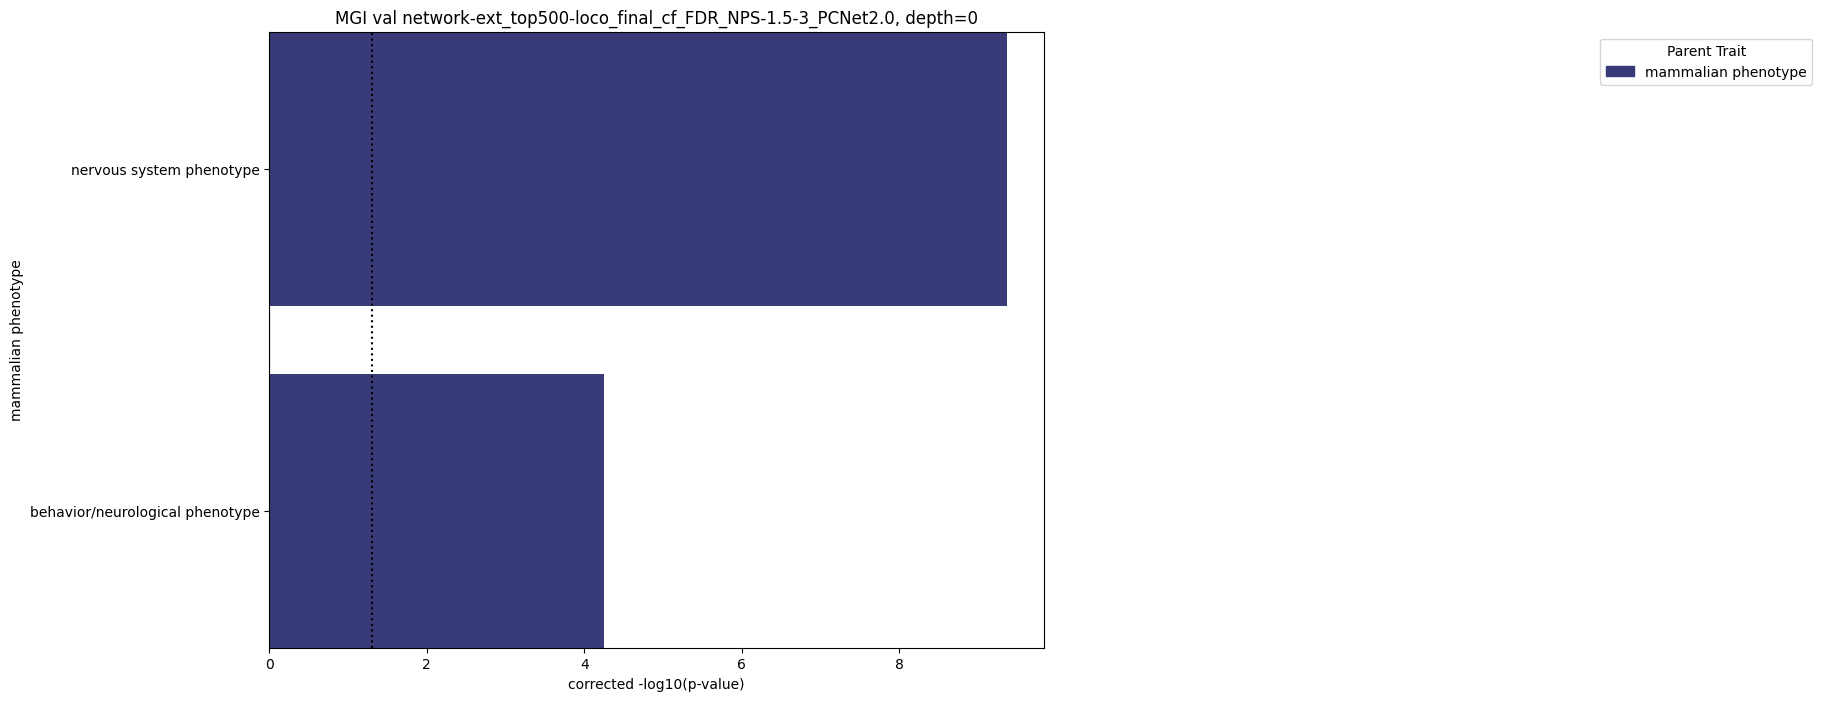

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

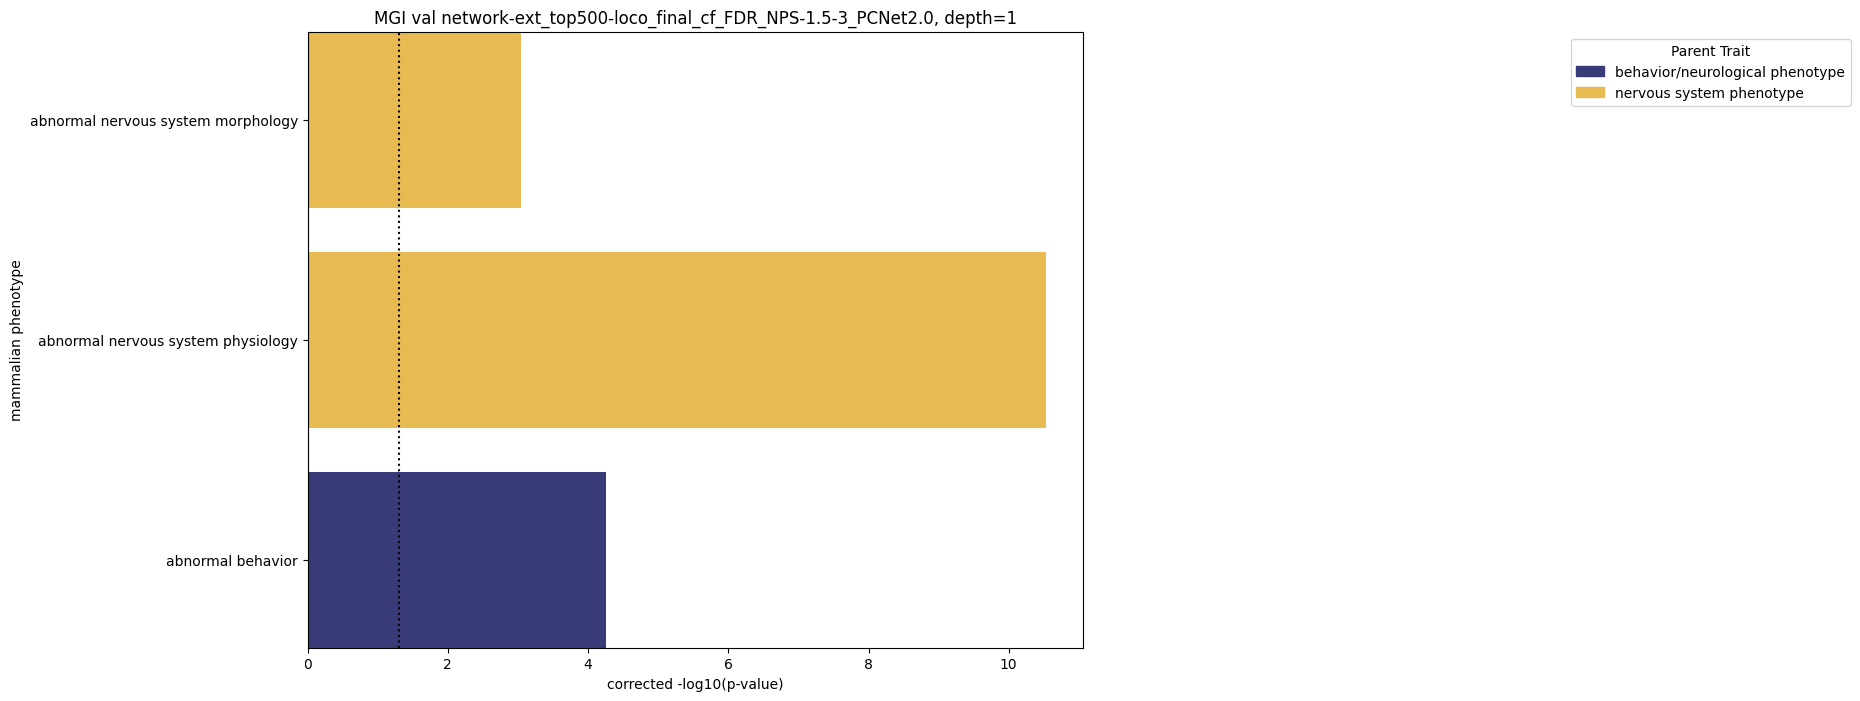

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

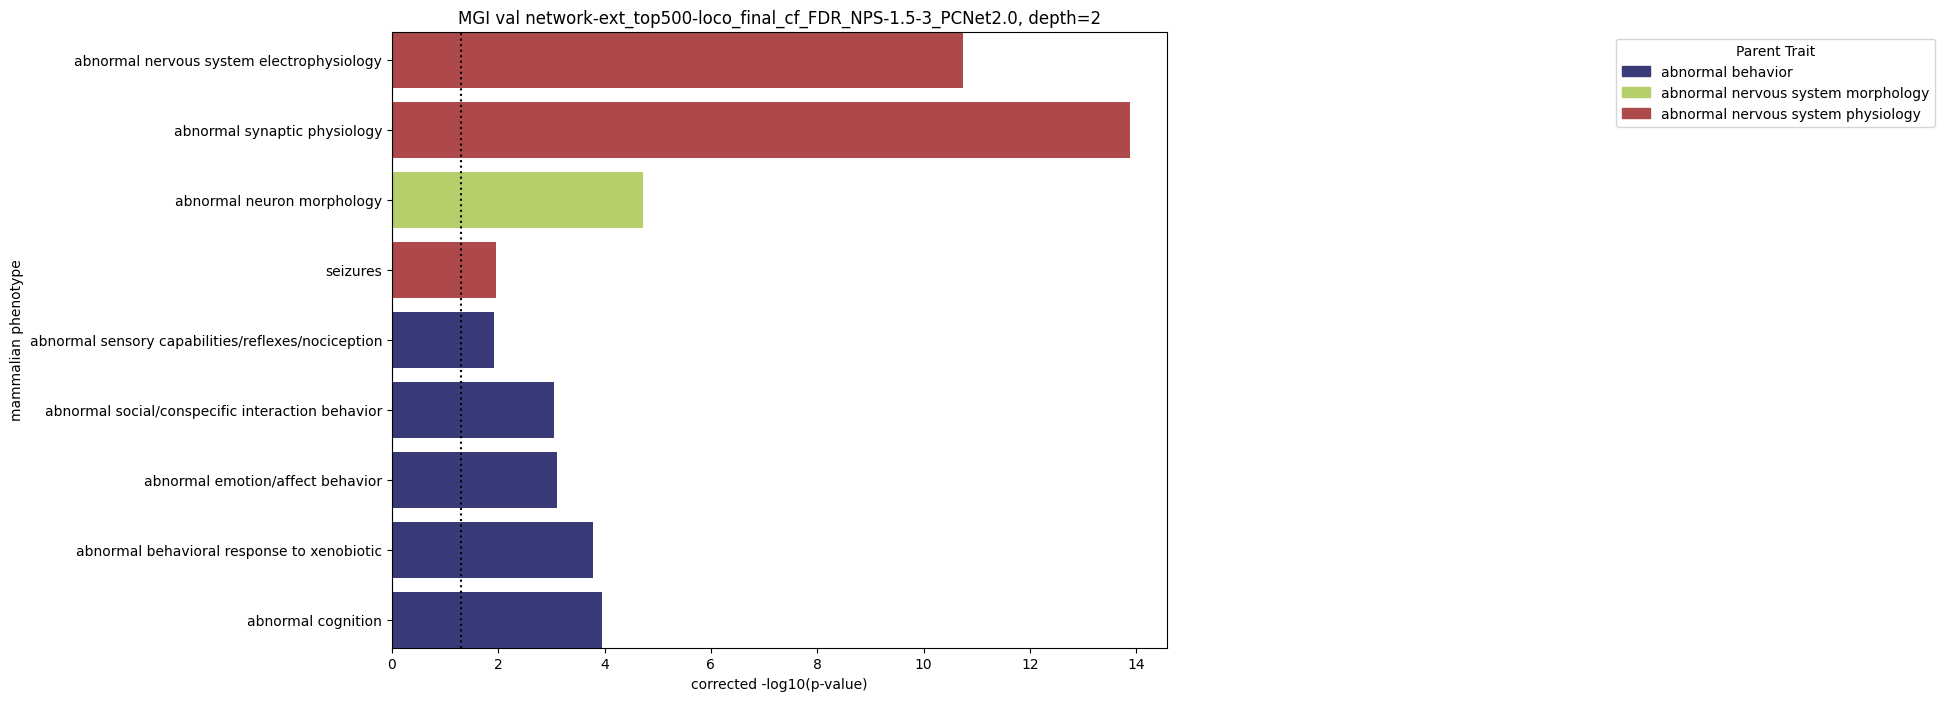

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

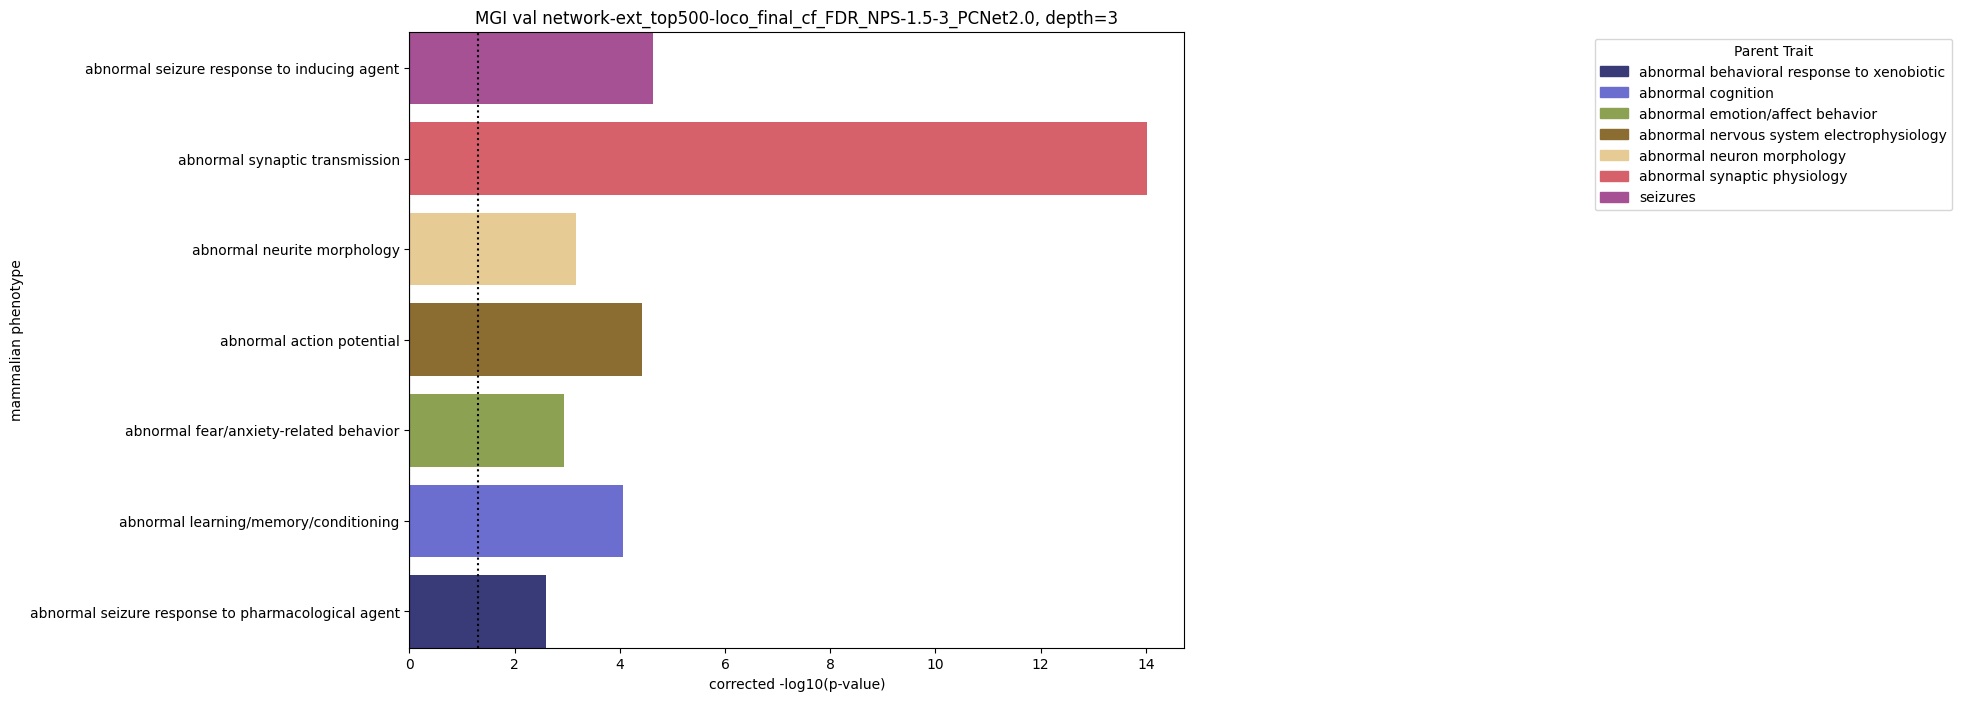

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

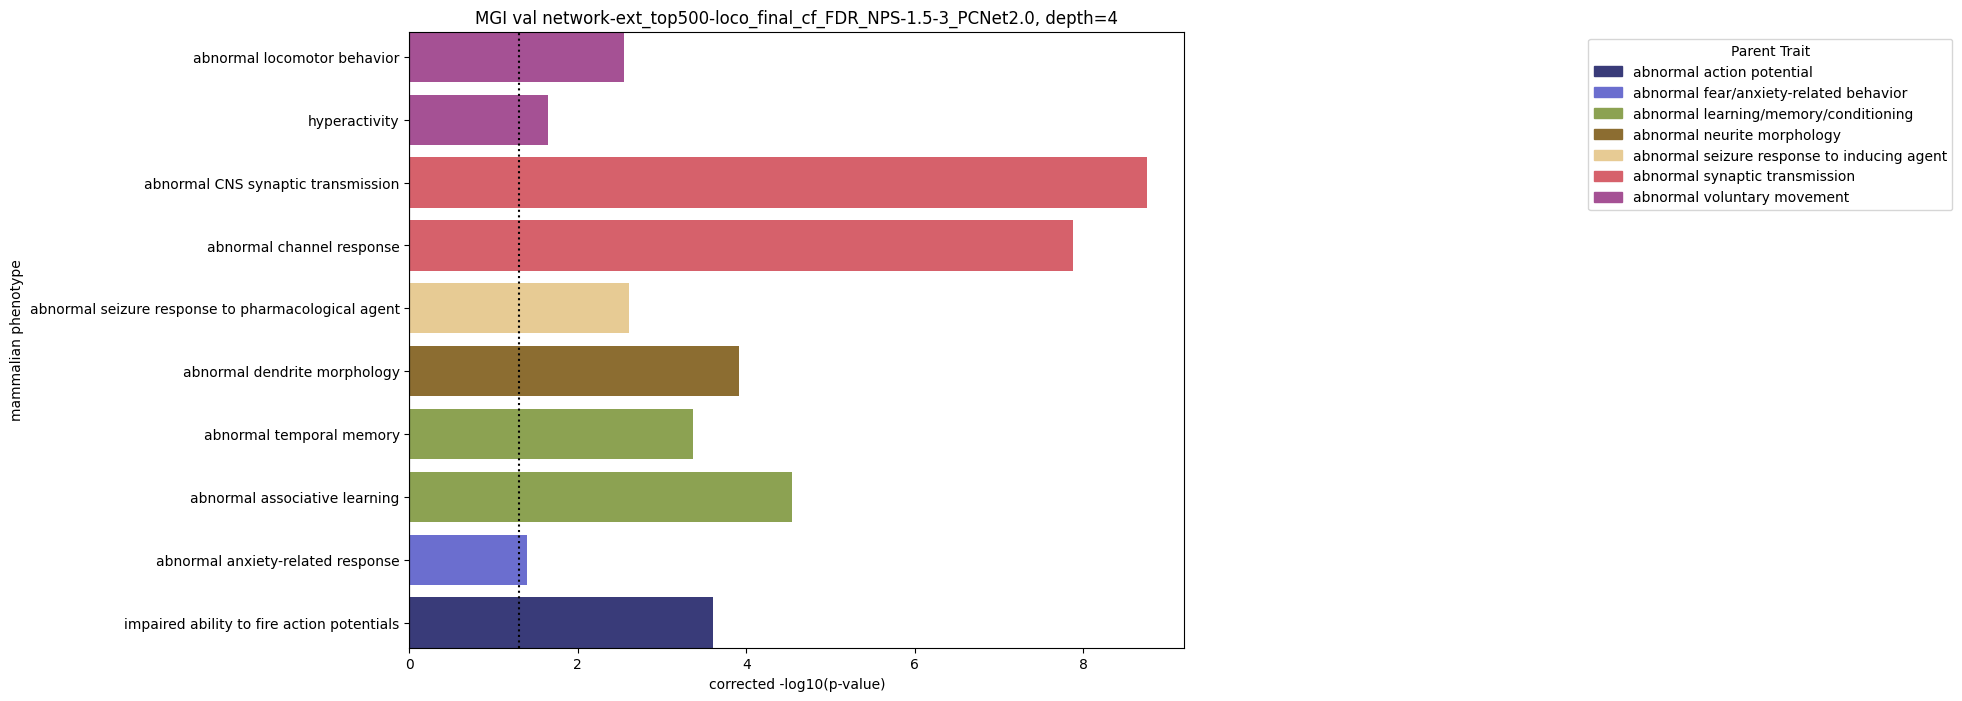

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

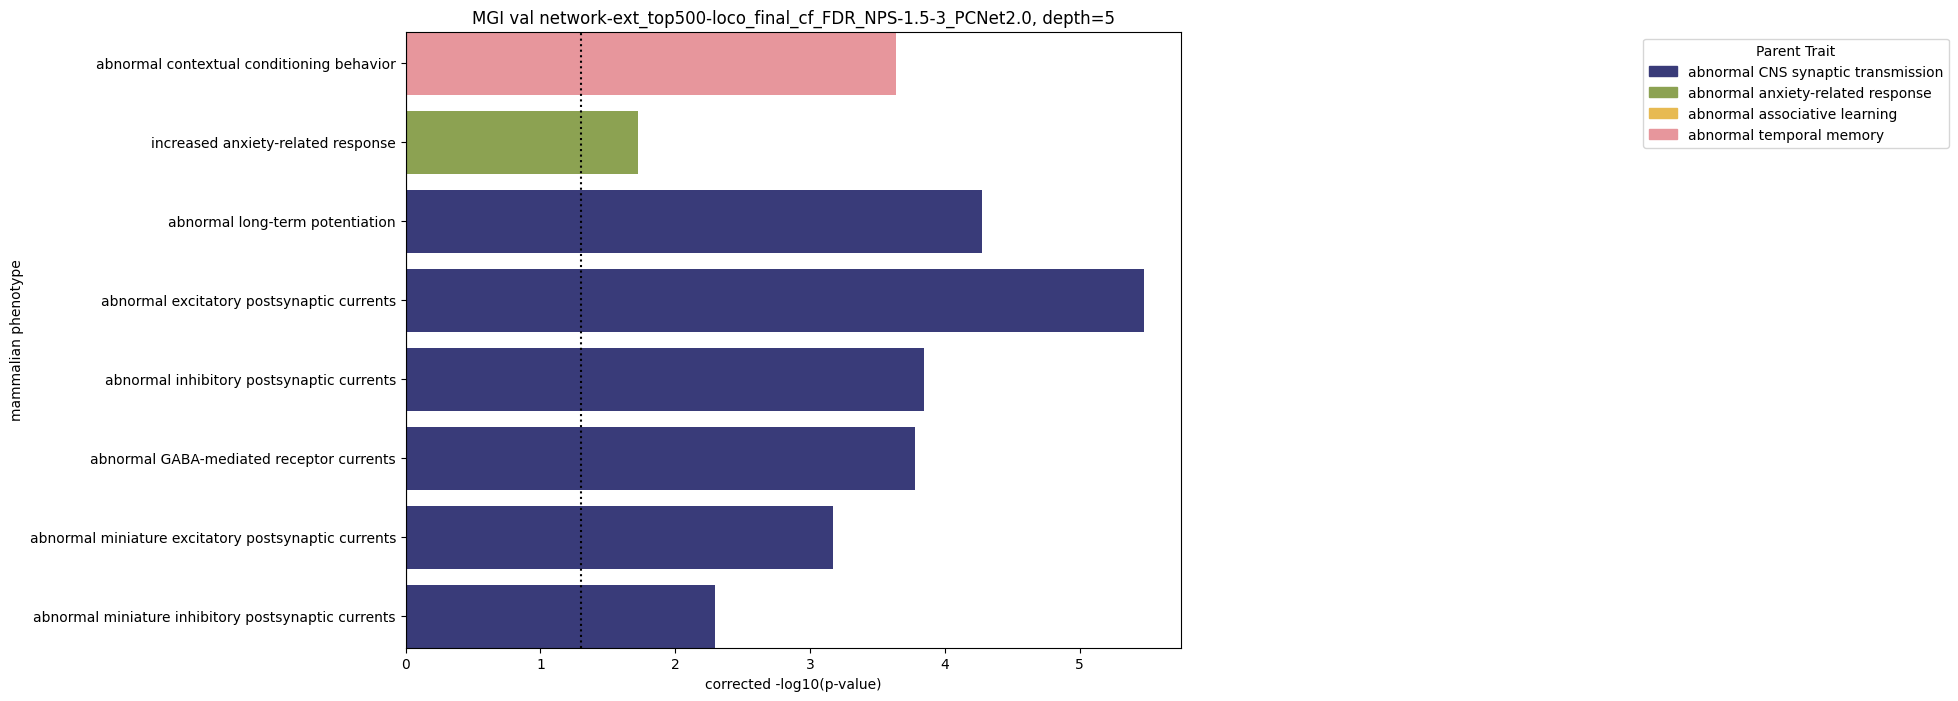

/scratch/bsleger/job_5840303/ipykernel_1632410/3114498060.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

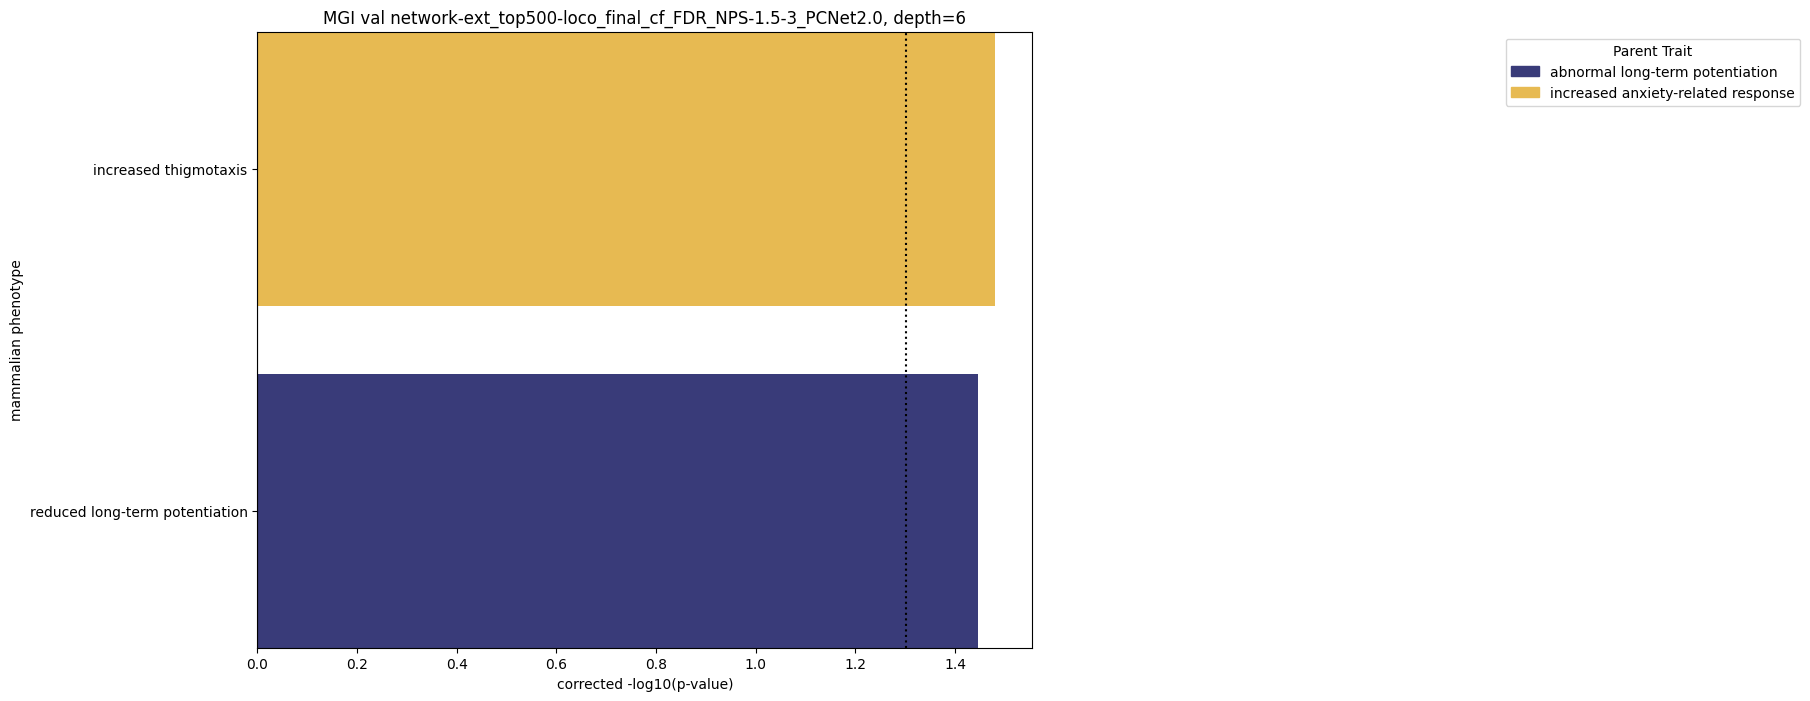

<Figure size 640x480 with 0 Axes>

In [154]:
for d in range(0, max(tbl.depth)+1):
    t = tbl[tbl['depth'] == d]
    t=t[t['p_intersect']<sigcut]
    t=t.reset_index()
    if (len(t)>0):
        t=t.sort_values('parent_trait',ascending=True)
        # Assign a unique color for each parent_trait based on its index
        unique_traits = t.parent_trait.unique()
        color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
        
        # Plotting
        fig = plt.figure(figsize=(10, 8))
        colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait
        
        plt.barh(y=t.trait, width=-np.log10((t.p_intersect*len_t)),label=t.parent_trait, color=colors)
        
        plt.ylabel('mammalian phenotype')
        plt.xlabel('corrected -log10(p-value)')
        plt.axvline(-np.log10(0.05), color='black', ls=':')
        plt.axvline(0, color='black', ls='-')
    
        #plt.xticks(rotation=90)
        #plt.title(d)
        plt.title(f'MGI val {val_lab_dict[sub_community]}, depth={d}')
        # Create legend patches (only one for each unique parent_trait)
        legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
        
        # Add legend to the plot
        plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
        plt.tight_layout()
        plt.margins(y=0)
        # Show the plot
        if save_fig:
            if not filter_traits:
                plt.savefig((f'{outpath_dir}/MGI_val_bar_depth-{d}.svg'), bbox_inches = "tight")
            else:
                plt.savefig((f'{outpath_dir}/MGI_val_filtered_bar_depth-{d}.svg'), bbox_inches = "tight")

        plt.show()

        # Clear the figure after showing
        plt.clf()

# barplot for figures

In [32]:
save_fig=False

In [39]:
outpath_dir

'validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr'

In [45]:
plt.rcParams.update({'font.size': 16})

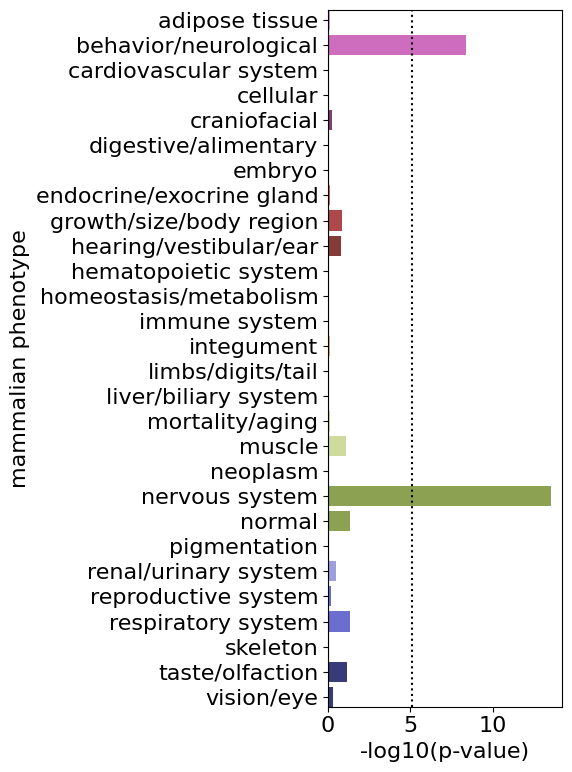

<Figure size 640x480 with 0 Axes>

In [158]:
d=0
t = tbl[tbl['depth'] == d]
t=t.sort_values('trait',ascending=False)
len_t=len(tbl)
#t=t[t['p_intersect']<0.05/len(t)]
# Assign a unique color for each parent_trait based on its index
unique_traits = t.trait.unique()
color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}

# Plotting
fig = plt.figure(figsize=(6, 8))
colors = [color_mapping[trait] for trait in t.trait]  # Color assignment based on parent_trait

plt.barh(y=t.trait.str.replace(' phenotype',''), width=-np.log10((t.p_intersect)),label=t.parent_trait, color=colors)

plt.ylabel('mammalian phenotype')
plt.xlabel('-log10(p-value)')
plt.axvline(-np.log10(0.05/len_t), color='black', ls=':')
plt.axvline(0, color='black', ls='-')

#plt.xticks(rotation=90)
#plt.title(d)
# Create legend patches (only one for each unique parent_trait)
legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]

# Add legend to the plot
#plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
plt.tight_layout()
plt.margins(y=0)
# Show the plot
if save_fig:
    plt.savefig((f'{outpath_dir}/MGI_val_depth-{str(d)}_for_publication.svg'), bbox_inches = "tight")
#plt.savefig(('MGI_val_depth-'+str(d)+'.svg'), bbox_inches = "tight")
plt.show()

# Clear the figure after showing
plt.clf()

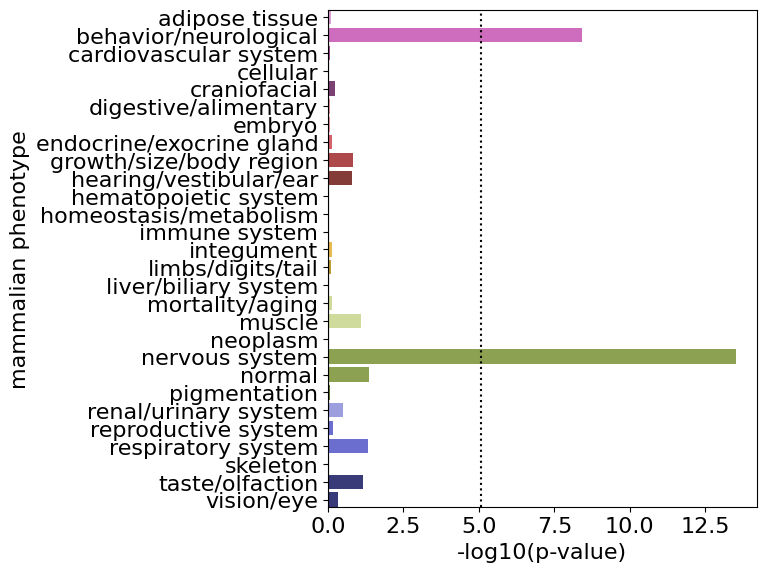

<Figure size 640x480 with 0 Axes>

In [49]:
d=0
t = tbl[tbl['depth'] == d]
t=t.sort_values('trait',ascending=False)
len_t=len(tbl)
#t=t[t['p_intersect']<0.05/len(t)]
# Assign a unique color for each parent_trait based on its index
unique_traits = t.trait.unique()
color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}

# Plotting
fig = plt.figure(figsize=(8, 6))
colors = [color_mapping[trait] for trait in t.trait]  # Color assignment based on parent_trait

plt.barh(y=t.trait.str.replace(' phenotype',''), width=-np.log10((t.p_intersect)),label=t.parent_trait, color=colors)

plt.ylabel('mammalian phenotype')
plt.xlabel('-log10(p-value)')
plt.axvline(-np.log10(0.05/len_t), color='black', ls=':')
plt.axvline(0, color='black', ls='-')

#plt.xticks(rotation=90)
#plt.title(d)
# Create legend patches (only one for each unique parent_trait)
legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]

# Add legend to the plot
#plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
plt.tight_layout()
plt.margins(y=0)
# Show the plot
if save_fig:
    plt.savefig((f'{outpath_dir}/MGI_val_depth-{str(d)}_for_slides.svg'), bbox_inches = "tight")
#plt.savefig(('MGI_val_depth-'+str(d)+'.svg'), bbox_inches = "tight")
plt.show()

# Clear the figure after showing
plt.clf()

In [159]:
color_mapping={'muscle phenotype':'#E7969C',
'nervous system phenotype':'#B5CF6B',
'behavior/neurological phenotype':'#A55194'}

In [160]:
with open('GWAS_catalog_parent_terms.txt') as json_file:
    par_dict = json.load(json_file)

In [161]:
par_dict=tbl[tbl['depth']==1][['trait','parent_trait']]
par_dict.index=par_dict.trait
par_dict=par_dict['parent_trait'].to_dict()

In [162]:
len(coloc_dict['net'])

263

/scratch/bsleger/job_5840303/ipykernel_1632410/1270037015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['grand_parent_trait']=[par_dict[k] for k in t.parent_trait]
/scratch/bsleger/job_5840303/ipykernel_1632410/1270037015.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


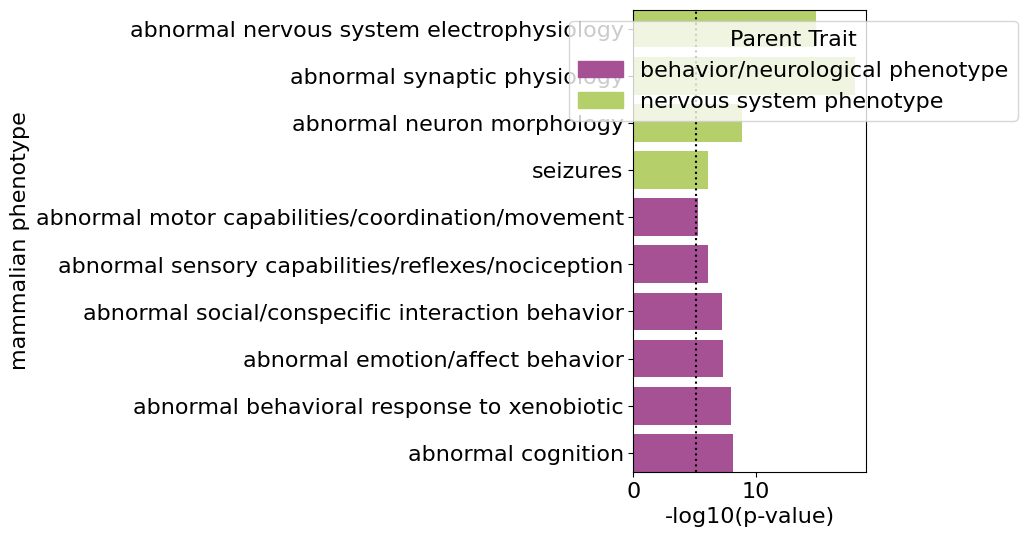

<Figure size 640x480 with 0 Axes>

In [163]:
d=2
t = tbl[tbl['depth'] == d]
t['grand_parent_trait']=[par_dict[k] for k in t.parent_trait]
t=t[t['p_intersect']<0.05/len(tbl)]
#t=t.sort_values('grand_parent_trait',ascending=True).reset_index()
t=t.sort_values('parent_trait')
len_t=len(tbl)

# Assign a unique color for each parent_trait based on its index
unique_traits = set(t.grand_parent_trait)
#color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
color_mapping={'muscle phenotype':'#E7969C',
'nervous system phenotype':'#B5CF6B',
'behavior/neurological phenotype':'#A55194'}
# Plotting
fig = plt.figure(figsize=(3, 6))
colors = [color_mapping[trait] for trait in t.grand_parent_trait]  # Color assignment based on parent_trait

#colors=(['#A55194']*6)+['#E7969C']+(['#B5CF6B']*8)
plt.barh(y=t.trait, width=-np.log10(t.p_intersect),label=t.grand_parent_trait.str.replace('phenotype',''), color=colors)

plt.ylabel('mammalian phenotype')
plt.xlabel('-log10(p-value)')
plt.axvline(-np.log10(0.05/len_t), color='black', ls=':')
#plt.xticks(rotation=90)
#plt.title(d)
# Create legend patches (only one for each unique parent_trait)
legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]

# Add legend to the plot
plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(1.7, 1))
plt.tight_layout()
plt.margins(y=0)
# Show the plot
if save_fig:
    plt.savefig((f'{outpath_dir}/MGI_val_depth-{str(d)}_for_publication.svg'), bbox_inches = "tight")

plt.show()

# Clear the figure after showing
plt.clf()

# run enrichment as loop over list of human traits

In [41]:
human_traits=['ext_db:FDR',
 'ext_rtb:bonf',
 'bmi:top500',
 'dpw:bonf',
 'maternal_smok:FDR',
 'park:bonf',
 'adhd:FDR']

In [46]:
for t in human_traits:
    #modify for correct genesets
    trait_r='loco_final_cf'
    cut_r= 'FDR'
    
    trait_h=t.split(':')[0]
    cut_h=t.split(':')[1]
    
    
    #choose which community to check enrichment for
    #must be keys from coloc_dict
    
    #['seed_r', 'seed_h', 'seed_hr', 'net', 'graph', 'magma_hm_ref', 'magma_rat_ref', 'hm_net', 'rat_net', 'magma_hm_rat_overlap_ref']
    sub_community='net'
    
    label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)
    
    
    filter_traits=False
    gpt=genes_per_trait[(genes_per_trait.ngenes>=5)&(genes_per_trait.ngenes<=1e5)]
    
    #get rest of dat asdfasets based on what was specified above
    coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
    val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)
    
    
    #sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
    #whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
    if sub_community in val_lab_dict.keys():
        whole_community=coloc_dict_ref[sub_community]
        outpath=f'validation_output/MGI_enr_{val_lab_dict[sub_community]}_enr.csv'
    
    else:
        print('sub_community not in val_lab_dict- using graph as the whole_community')
        whole_community='graph'
        outpath='validation_output/MGI_enr_temp.csv'
    print(f'path for this output file: {outpath}')
    if (outpath=='validation_output/MGI_enr_temp.csv'):
        print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
    elif (os.path.isfile(outpath)):
        run_analysis=False
        print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
        tbl=pd.read_csv(outpath)
    else:
        run_analysis=True
        print('this analysis has not been run- run_analysis set to True')
    
    
    coloc_dict_cat={}
    for k in coloc_dict.keys():
        coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(mgi_df['human_ortholog'].dropna()))
    
    
    print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')
    
    if run_analysis:
        tbl=recurse_enrichment(par,graph,id_to_name, 
            name_to_id,'mammalian phenotype',mgi_df,'MP','human_ortholog',
            coloc_dict_cat,sub_community,
            whole_community,outpath,depth=0,depth_term=None,verbose=False,enr_concat=None)
        tbl.to_csv(outpath,index=False)
        print(f'table saved as {outpath}')
    
    if ('net' in sub_community):
        if not 'n_seed' in tbl.columns: #comment out to fix fucked ones
            if 'community_genes' in tbl.columns:
                col='community_genes'
            else:
                col='network_genes'
            if type(tbl[col].iloc[0])!=set:
                tbl['seed_h']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(', ')).intersection(coloc_dict['seed_h']))
                tbl['seed_r']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(', ')).intersection(coloc_dict['seed_r']))
            else:
                tbl['seed_h']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_h']))
                tbl['seed_r']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_r']))
            tbl['n_seed_h']=tbl.seed_h.apply(lambda x: len(list(x)))
            tbl['n_seed_r']=tbl.seed_r.apply(lambda x: len(list(x)))
            tbl['n_seed']=tbl.apply(lambda row: len(row['seed_h'] | row['seed_r']), axis=1)
            if not filter_traits:
                tbl.to_csv(outpath,index=False)
            tbl.sort_values('n_seed',ascending=False).head()

path for this output file: validation_output/MGI_enr_network-ext_db_FDR-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
this analysis has not been run- run_analysis set to True
	THIS IS CALCULATED FROM loco_final_cf_FDR, ext_db_FDR, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)
analyzing structure depth=0
	length of enrichment table=28
	length of concatenated enrichment table=28
	length of children=28
analyzing structure depth=1
	length of enrichment table=82
	length of concatenated enrichment table=110
	length of children=82
analyzing structure depth=2
	length of enrichment table=442
	length of concatenated enrichment table=552
	length of children=414
analyzing structure depth=3
	length of enrichment table=1092
	length of concatenated enrichment table=1644
	length of children=966
analyzing structure depth=4
	length of enrichment table=1397
	length of concatenated enrichment table=3041
	length of children=1229
analyzing structure depth=5
	length of enrichment table=1517
	length of concat